<a href="https://colab.research.google.com/github/felixlys/forecast_with_StochProcess/blob/main/Forecasting_ARIMA_BBCA_JK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Peramalan Harga Saham BBCA.JK dengan Menggunakan ARIMA

Pada penelitian ini, dilakukan peramalan harga saham BBCA.JK periode 12 Juni 2024 -1 November 2024(data 100 hari) dengan menggunakan data 1 Juli 2019-1 November 2024( data 1953 Hari). Dengan tahapan sebagai berikut :


# 1.   Pengambilan Data Saham
Adapun sumber data harga saham berasal dari Yahoo Finance. Pada penelitian ini, data harga yang digunakan adalah data Close Price BBCA.JK

In [1]:
install.packages("quantmod")
library(quantmod)
BBCA_data<-getSymbols(Symbols="BBCA.JK",src="yahoo",from=Sys.Date()-1953,to=Sys.Date(),auto.assign=FALSE)
head(BBCA_data)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



           BBCA.JK.Open BBCA.JK.High BBCA.JK.Low BBCA.JK.Close BBCA.JK.Volume
2019-07-01         5995         6025        5965          5990       56612500
2019-07-02         5990         6000        5950          6000       48563500
2019-07-03         5950         6000        5940          6000       43640000
2019-07-04         6000         6010        5965          5990       28224500
2019-07-05         6020         6020        5970          5970       32722500
2019-07-08         5935         5960        5865          5880       38361000
           BBCA.JK.Adjusted
2019-07-01         5381.989
2019-07-02         5390.974
2019-07-03         5390.974
2019-07-04         5381.989
2019-07-05         5364.020
2019-07-08         5283.155

           BBCA.JK.Close
2019-07-01          5990
2019-07-02          6000
2019-07-03          6000
2019-07-04          5990
2019-07-05          5970
2019-07-08          5880

           BBCA.JK.Close
2024-10-25         10750
2024-10-28         10600
2024-10-29         10500
2024-10-30         10350
2024-10-31         10250
2024-11-01         10425

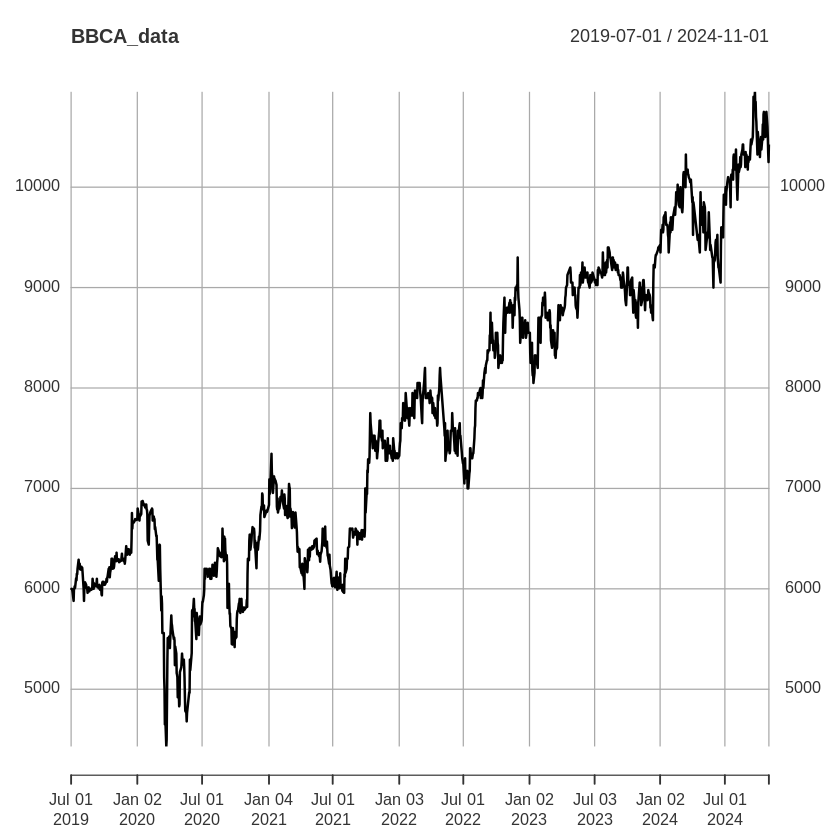

In [9]:
BBCA_data<-Cl(BBCA_data)
head(BBCA_data)
tail(BBCA_data)
plot(BBCA_data)

Tampak bahwa data Close Price BBCA memiliki tren naik.

# 2.   Dapatkan Log Price
Berdasarkan asumsi ekonomi, ekspektasi pertumbuhan harga saham merupakan *Continously Compounded Interest Rate*, yakni bunga yang dibayarkan secara kontinu sehingga model matematika harga saham ke-t adalah
$$S_{t}=S_{0}e^{\mu t},t\geq 0$$
dengan $\mu$ merupakan rate of return kontinu. Sehingga untuk mendapatkan rate of return nya disetiap hari-hari trading digunakan formula
$$\mu_{t}=\ln\bigg(\frac{S_{t}}{S_{t-1}}\bigg)=\ln(S_{t})-\ln(S_{t-1})$$.

Untuk itu pada tahap kedua, akan dicari log price BBCA_JK terlebih dahulu, kemudian dilakukan pengecekan kurva ACF dan PACF, namun jika terbukti log price tidak stasioner, maka dilakukan differencing untuk mendapatkan  $\mu_{t}$.

